In [24]:
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client
import pde
import phasesep as ps

## Setting  up Dask cluster

In [75]:
cluster = HTCondorCluster(
    cores=8,
    memory="5GB",
    disk="10GB",
    processes=8,
    local_directory="$TMPDIR",
    log_directory="/home/ole.berendes/dasklogs",
    job_extra={"+MaxRunTime": 86400}
)

/home/ole.berendes/miniconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 25169 instead
  warnings.warn(


In [76]:
cluster.scale(1)
cluster

In [77]:
client = Client(cluster)
client

<Client: 'tcp://134.76.97.134:9098' processes=8 threads=8, memory=4.66 GiB>

## Setting up the system

### Free energy density

In [7]:
f_scale = 1
f_slope = 0.02
f_offset = 0
kappa = 1
diffusive_mobility = 1
noise_diffusion = 2/30

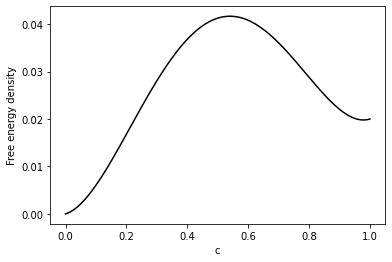

In [8]:

f = ps.GinzburgLandau2Components(
    prefactor=f_scale,
    slope=f_slope,
    offset=f_offset
)
f.plot()

In [9]:
binodal = f.get_binodal()[0][0]
spinodal = f.get_spinodal()[0]
binodal_range = spinodal - binodal

print("Binodal: ", binodal)
print("Spinodal: ", spinodal)
print("length of binodal range", binodal_range)

Binodal:  6.430877621984597e-18
Spinodal:  0.21132486540518688
length of binodal range 0.21132486540518688


### Equation

In [10]:
eq = ps.CahnHilliardExtendedPDE(
    {
        "free_energy": f,
        "kappa": kappa,
        "mobility": diffusive_mobility,
        "noise_diffusion": noise_diffusion
    }
)

## Solve pde

### Define grid

In [11]:
nx, ny = 32, 32
x_start, x_end = -16, 16
y_start, y_end = -16, 16
grid = pde.CartesianGrid(
    bounds=[(x_start, x_end), (y_start, y_end)],
    shape=[nx,ny],
    periodic=True)

### Initial state

phi_0:  0.04226497308103739


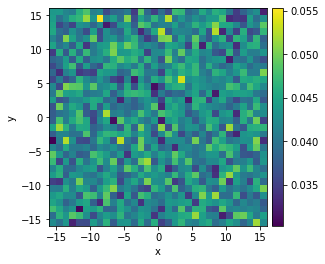

In [12]:
phi0 = binodal + 0.2*binodal_range
print("phi_0: ",phi0)

initial_field = pde.ScalarField.random_normal(
    grid=grid,
    mean=phi0,
    std=phi0*0.1
)

initial_field.plot()

In [83]:
dt = 1e-3

In [89]:
def integrate(initial_state, t_end, dt=dt, eq=eq):
    final = eq.solve(
        state=initial_state,
        t_range=t_end,
        method="explicit",
        dt=dt
    )

    return final